In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.utils import make_grid, save_image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os
from torch.utils.tensorboard import SummaryWriter
from torchmetrics.image.fid import FrechetInceptionDistance

ModuleNotFoundError: No module named 'torchmetrics'

In [9]:
# 初始化权重
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)

# 生成器
class Generator(nn.Module):
    def __init__(self, noise_dim, img_channels, feature_g):
        # 继承nn.Module，并使用它的初始化函数
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, feature_g * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_g * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_g * 8, feature_g * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_g * 4, feature_g * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_g * 2, feature_g, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_g, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.gen(x)

# 判别器
class Discriminator(nn.Module):
    def __init__(self, img_channels, feature_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(img_channels, feature_d, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d, feature_d * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_d * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d * 2, feature_d * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_d * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d * 4, feature_d * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_d * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.disc(x)


In [10]:
# 超参数
device = 'cuda' if torch.cuda.is_available() else 'cpu'
noise_dim = 100  # 噪声向量维度
img_size = 64
img_channels = 3  # RGB图像
feature_g = 128  # 生成器特征数
feature_d = 128  # 判别器特征数
batch_size = 128
epochs = 1000

# 实例化模型
gen = Generator(noise_dim, img_channels, feature_g).to(device)
disc = Discriminator(img_channels, feature_d).to(device)
# 应用weight_init函数随机初始化所有权重
gen.apply(weights_init)
disc.apply(weights_init)

# 损失函数和优化器
criterion = nn.BCELoss() # 使用二元交叉熵损失函数
optimizer_gen = optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_disc = optim.Adam(disc.parameters(), lr=0.0001, betas=(0.5, 0.999))

# 创建 TensorBoard 记录器
writer = SummaryWriter()

In [11]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# 数据集路径
data_dir = 'D:\\learn_pytorch\\pythonProject\\trump'  # 特朗普图像的文件夹路径

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # 将图像值标准化到 [-1, 1]
])

# 加载数据集
dataset = CustomImageDataset(root_dir=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [12]:
# 记录损失值
losses_disc = []
losses_gen = []

# 开始训练
for epoch in range(epochs):
    for batch_idx, real in enumerate(dataloader):
        real = real.to(device)
        batch_size = real.size(0)
        noise = torch.randn(batch_size, noise_dim, 1, 1, device=device) # 生成一个服从标准正态分布（均值为 0，标准差为 1）的随机张量

        # 训练判别器
        fake = gen(noise)
        disc_real = disc(real).view(-1)
        disc_fake = disc(fake.detach()).view(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        optimizer_disc.step()

        # 训练生成器
        output = disc(fake).view(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        optimizer_gen.step()

    # 记录损失值
    losses_disc.append(loss_disc.item())
    losses_gen.append(loss_gen.item())
    writer.add_scalar('Loss/Discriminator', loss_disc.item(), epoch)
    writer.add_scalar('Loss/Generator', loss_gen.item(), epoch)
    
    print(f"Epoch [{epoch+1}/{epochs}] | Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}")
    save_fold = 'D:\\learn_pytorch\\pythonProject\\generate_trump'
    # 每10个epoch保存样本图像
    if (epoch + 1) % 100 == 0:
        fake_images = gen(torch.randn(16, noise_dim, 1, 1, device=device)).detach()
        save_file = f'sample_{epoch+1}_v4.png'
        save_path = os.path.join(save_fold, save_file)
        save_image(fake_images, save_path, nrow=4, normalize=True)

# 关闭 TensorBoard 记录器
writer.close()

Epoch [1/1000] | Loss D: 0.6067, Loss G: 0.8890
Epoch [2/1000] | Loss D: 0.4079, Loss G: 1.3855
Epoch [3/1000] | Loss D: 0.1851, Loss G: 2.1523
Epoch [4/1000] | Loss D: 0.1168, Loss G: 2.5969
Epoch [5/1000] | Loss D: 0.0748, Loss G: 2.9719
Epoch [6/1000] | Loss D: 0.0449, Loss G: 3.3190
Epoch [7/1000] | Loss D: 0.0362, Loss G: 3.5529
Epoch [8/1000] | Loss D: 0.0340, Loss G: 3.7643
Epoch [9/1000] | Loss D: 0.5709, Loss G: 3.9082
Epoch [10/1000] | Loss D: 0.1020, Loss G: 3.7267
Epoch [11/1000] | Loss D: 0.0875, Loss G: 2.8411
Epoch [12/1000] | Loss D: 0.1394, Loss G: 3.7816
Epoch [13/1000] | Loss D: 0.2213, Loss G: 3.6232
Epoch [14/1000] | Loss D: 0.3641, Loss G: 4.6044
Epoch [15/1000] | Loss D: 0.2801, Loss G: 3.1316
Epoch [16/1000] | Loss D: 0.3312, Loss G: 2.8484
Epoch [17/1000] | Loss D: 1.1998, Loss G: 3.6812
Epoch [18/1000] | Loss D: 0.3407, Loss G: 2.6004
Epoch [19/1000] | Loss D: 0.2842, Loss G: 3.1659
Epoch [20/1000] | Loss D: 0.3515, Loss G: 3.0235
Epoch [21/1000] | Loss D: 0.3

KeyboardInterrupt: 

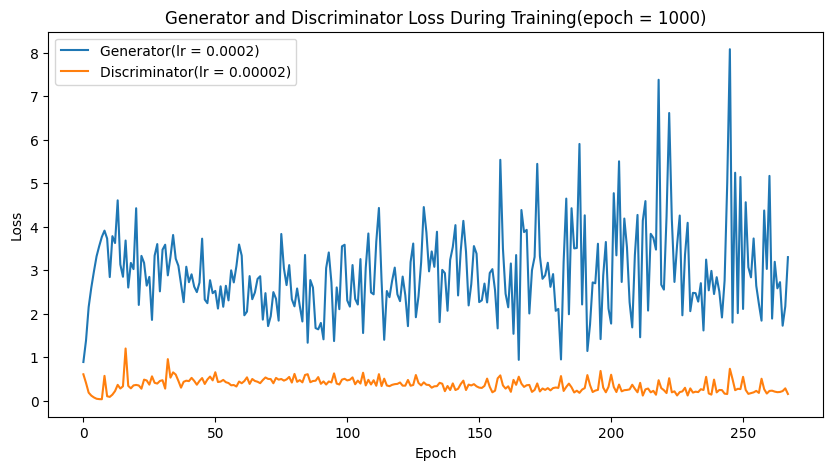

In [13]:
import matplotlib.pyplot as plt

# 绘制损失函数图
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training(epoch = 1000)")
plt.plot(losses_gen, label="Generator(lr = 0.0002)")
plt.plot(losses_disc, label="Discriminator(lr = 0.00002)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
with torch.no_grad():
    noise = torch.randn(16, noise_dim, 1, 1, device=device)
    fake_images = gen(noise)
    save_image(fake_images, 'generated_trump_images.png', nrow=4, normalize=True)
